# Satellite coverage analysis

This tutorial demonstrates how to calculate satellite coverage around a location, including access constraints, using Python and PySTK. It is inspired by [this training](https://help.agi.com/stk/Content/training/CoverageToolWizard.htm).

## Problem statement

The satellite graveyard is a location in the Pacific Ocean around a position known as Point Nemo, located at a latitude of $-48.87^\circ$ degrees and a longitude of $-123.39^\circ$ degrees. At $2688$ km away from any coastline, Point Nemo is a good location for disposing of inactive satellites. The satellite graveyard is modeled as an elliptical region around Point Nemo, with a semi-major axis of $2688$ km, a semi-minor axis of $2688$ km, and a bearing of $45^\circ$. A satellite flies over the globe with an on-board sensor with the aim of surveilling the satellite graveyard. The satellite has a J2Pertubation propagator, with an orbit with a semi-major axis of $6852.45$ km, an eccentricity of $0$, an inclination of $98^\circ$, an argument of perigee of $0^\circ$, a RAAN of $150.34^\circ$, and a true anomaly of $0^\circ$. The sensor is a simple conic sensor with a $45^\circ$ half angle and an angular resolution of $1^\circ$.


Determine how well the satellite covers this region. Additionally, determine how well the satellite covers the region if it collects ground imagery, requiring illumination of the surface of the Earth.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create a new scenario in STK by running:

In [2]:
root = stk.new_object_root()
root.new_scenario("SatGraveyardCoverage")

Once the scenario is created, it is possible to show a 3D graphics window by running:

RFBOutputContext()

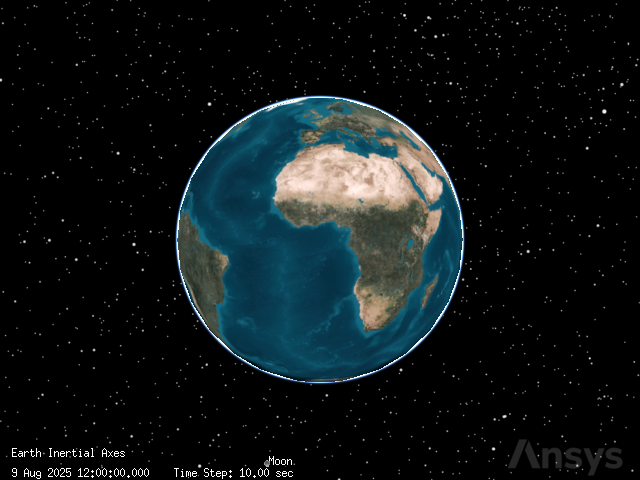

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [4]:
scenario = root.current_scenario
scenario.set_time_period("20 Jun 2023 16:00:00.000", "21 Jun 2023 16:00:00.000")
root.rewind()

## Add a satellite

The satellite orbits with a repeating ground trace orbit and a J2Pertubation propagator.

First, insert the satellite:

In [5]:
from ansys.stk.core.stkobjects import STKObjectType


satellite = scenario.children.new(STKObjectType.SATELLITE, "EarthObsSat")

Set the propagator to J2Pertubation:

In [6]:
from ansys.stk.core.stkobjects import PropagatorType


satellite.set_propagator_type(PropagatorType.J2_PERTURBATION)
propagator = satellite.propagator

The satellite has an orbit with a semi-major axis of $6852.45$ km, an eccentricity of $0$, an inclination of $98^\circ$, an argument of perigee of $0^\circ$, a RAAN of $150.34^\circ$, and a true anomaly of $0^\circ$.

First, set the orbit's coordinate type to classical:

In [7]:
from ansys.stk.core.stkutil import OrbitStateType


orbit = propagator.initial_state.representation.convert_to(OrbitStateType.CLASSICAL)

Use the returned ``IOrbitStateClassical`` object to set the ``size_shape_type`` property. This property designates which pair of elements describe the orbit. Set the ``size_shape_type`` to Semi-major Axis and Eccentricity:

In [8]:
from ansys.stk.core.stkobjects import ClassicalSizeShape


orbit.size_shape_type = ClassicalSizeShape.SEMIMAJOR_AXIS

Set the orbit's semi-major axis to $6852.45$ km and it's eccentricity to $0$:

In [9]:
orbit.size_shape.semi_major_axis = 6852.45
orbit.size_shape.eccentricity = 0

Then, use the `orientation` property of the `IOrbitStateClassical` object to set the inclination to $98^\circ$ and the argument of perigee to $0^\circ$:

In [10]:
orbit.orientation.inclination = 98
orbit.orientation.argument_of_periapsis = 0

Using the orientation property, set the ascending node type to RAAN:

In [11]:
from ansys.stk.core.stkobjects import OrientationAscNode


orbit.orientation.ascending_node_type = (
    OrientationAscNode.RIGHT_ASCENSION_ASCENDING_NODE
)

Set the RAAN value to $150.34^\circ$:

In [12]:
orbit.orientation.ascending_node.value = 150.34

Then, use the `location` property of the `IOrbitStateClassical` object to set the location type to true anomaly:

In [13]:
from ansys.stk.core.stkobjects import ClassicalLocation


orbit.location_type = ClassicalLocation.TRUE_ANOMALY

Set the true anomaly value to $0^\circ$:

In [14]:
orbit.location.value = 0

Finally, assign the orbit as the satellite propagator's initial state representation, and propagate the satellite:

In [15]:
satellite.propagator.initial_state.representation.assign(orbit)
satellite.propagator.propagate()

## Insert a sensor

The satellite has a fixed sensor with a simple conic pattern. This sensor looks down on Earth, and can see any location in its field of view. This sensor is used to image the satellite graveyard.

First, insert a sensor on the satellite. The sensor has a fixed sensor type by default.

In [16]:
sensor = satellite.children.new(STKObjectType.SENSOR, "SatelliteSensor")

Then, set the sensor's type to a simple conic sensor with a $45^\circ$ half angle and an angular resolution of $1^\circ$:

In [17]:
from ansys.stk.core.stkobjects import SensorPattern


sensor.set_pattern_type(SensorPattern.SIMPLE_CONIC)
sensor.common_tasks.set_pattern_simple_conic(45, 1)

## Insert a place

Insert a place object to represent Point Nemo:

In [18]:
point_nemo = scenario.children.new(STKObjectType.PLACE, "PointNemo")

Point Nemo is located at a latitude of $-48.87^\circ$ degrees and a longitude of $-123.39^\circ$ degrees. Assign its location using geodetic coordinates:

In [19]:
point_nemo.position.assign_geodetic(-48.87, -123.39, 0)

## Insert a coverage definition

Use a coverage definition to calculate satellite coverage around Point Nemo. The coverage definition represents the satellite graveyard. This definition is used to calculate how much of the satellite graveyard the sensor on the imaging satellite can see at any time.

First, insert the coverage definition:

In [20]:
sat_grave_coverage = scenario.children.new(
    STKObjectType.COVERAGE_DEFINITION, "SatelliteGraveyard"
)

The coverage definition should represent the satellite graveyard, which consists of an ellipse around Point Nemo, with a semi-major axis of $2688$ km, a semi-minor axis of $2688$ km, a bearing of $45^\circ$. The definition has a latitude/longitude point granularity of $2^\circ$.

To set the coverage definition's bounds to the elliptical area around Point Nemo, first set the bounds type to use custom regions:

In [21]:
from ansys.stk.core.stkobjects import CoverageBounds


sat_grave_coverage.grid.bounds_type = CoverageBounds.CUSTOM_REGIONS

Then, assign Point Nemo as the center of the ellipse used to calculate the coverage:

In [22]:
ellipse = sat_grave_coverage.grid.bounds.ellipses.add(point_nemo.path)

Next, set the ellipse's semi-major axis to $2688$ km, semi-minor axis to $2688$ km, and bearing to $45^\circ$:

In [23]:
ellipse.semi_major_axis = 2688
ellipse.semi_minor_axis = 2688
ellipse.bearing = 45

Finally, configure the coverage definition's grid point granularity. The grid point granularity presents a trade-off between computational workload and accuracy of results. A higher granularity provides higher accuracy at the cost of a higher workload. For this example, set the resolution to $2^\circ$ latitude/longitude.

First, set the grid's resolution to use a latitude/longitude resolution:

In [24]:
from ansys.stk.core.stkobjects import CoverageResolution


sat_grave_coverage.grid.resolution_type = (
    CoverageResolution.RESOLUTION_LATITUDE_LONGITUDE
)

Then, set the resolution to $2^\circ$:

In [25]:
sat_grave_coverage.grid.resolution.latitude_longitude = 2

It is now possible to see the coverage definition in the 3D graphics widget:

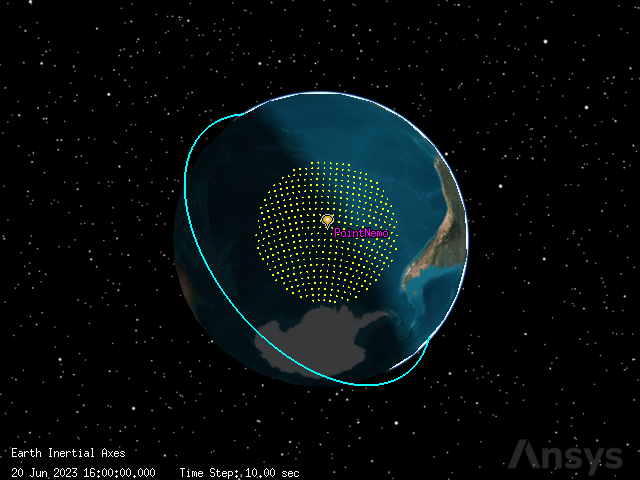

In [26]:
globe_plotter.camera.position = [19580, 7520, -26710]
globe_plotter.show()

## Compute coverage

It is necessary to determine how much of the satellite graveyard can be seen by the satellite's sensor at different times. To do so, first assign the satellite's sensor as an asset on the coverage:

In [27]:
sat_grave_coverage.asset_list.add(sensor.path)

Then, compute the accesses between the coverage area and the sensor:

In [28]:
sat_grave_coverage.compute_accesses()

## Analyze the results with a Figure of Merit

Use a Figure of Merit to assess the quality of coverage over the coverage definition. The Figure of Merit must register when the coverage definition's area is covered by the satellite, so the Figure of Merit's definition type should be simple coverage.

First, insert a Figure of Merit:

In [29]:
figure_of_merit = sat_grave_coverage.children.new(
    STKObjectType.FIGURE_OF_MERIT, "Coverage"
)

Then, set the Figure of Merit's definition type to simple coverage:

In [30]:
from ansys.stk.core.stkobjects import FigureOfMeritDefinitionType


figure_of_merit.set_definition_type(FigureOfMeritDefinitionType.SIMPLE_COVERAGE)

## Create a Satisfied by Time report

Find the overall percent satisfaction of the Figure of Merit using the Satisfied by Time report. The last percent accumulation coverage value corresponds to the overall percent satisfaction.

Select the Figure of Merit's Satisfied by Time report and convert it to a pandas ``dataframe``:

In [31]:
satisfied_by_time_df = (
    figure_of_merit.data_providers.item("Satisfied by Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

In [32]:
satisfied_by_time_df

,time,percent satisfied,area satisfied,percent accum coverage,accum area coverage
0,20 Jun 2023 16:00:00.000000000,0.0,0.0,0.0,0.0
1,20 Jun 2023 16:01:00.000000000,0.0,0.0,0.0,0.0
2,20 Jun 2023 16:02:00.000000000,0.0,0.0,0.0,0.0
3,20 Jun 2023 16:03:00.000000000,0.0,0.0,0.0,0.0
4,20 Jun 2023 16:04:00.000000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1436,21 Jun 2023 15:56:00.000000000,0.0,0.0,85.67693168647978,19097375.08673233
1437,21 Jun 2023 15:57:00.000000000,0.0,0.0,85.67693168647978,19097375.08673233
1438,21 Jun 2023 15:58:00.000000000,0.0,0.0,85.67693168647978,19097375.08673233
1439,21 Jun 2023 15:59:00.000000000,0.0,0.0,85.67693168647978,19097375.08673233


The overall satisfaction of the coverage was $85.68$%.

Visualize the data with a line chart:

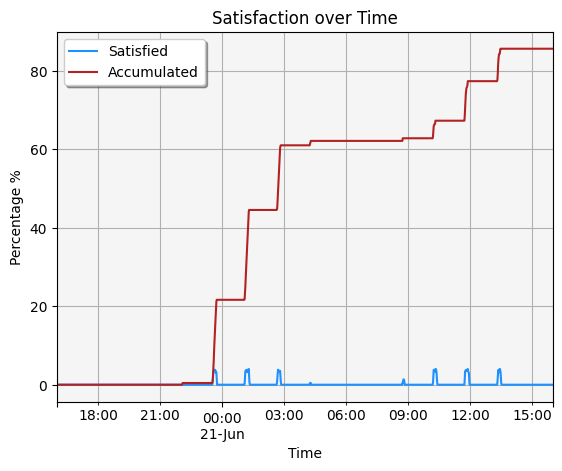

In [33]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert data to correct types
satisfied_by_time_df["time"] = pd.to_datetime(satisfied_by_time_df["time"])
satisfied_by_time_df.set_index("time")
satisfied_by_time_df["percent satisfied"] = pd.to_numeric(
    satisfied_by_time_df["percent satisfied"]
)
satisfied_by_time_df["percent accum coverage"] = pd.to_numeric(
    satisfied_by_time_df["percent accum coverage"]
)

# Plot data
ax = satisfied_by_time_df.plot(
    x="time", y="percent satisfied", color="dodgerblue", label="Satisfied"
)
ax = satisfied_by_time_df.plot(
    x="time", y="percent accum coverage", color="firebrick", ax=ax, label="Accumulated"
)

# Set title and axes labels
ax.set_title("Satisfaction over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Percentage %")

# Configure style
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")
ax.legend(shadow=True)

plt.show()

The spikes in the blue line correspond to when the satellite's sensor is directly overhead of the region.

## Visualize the results with the Figure of Merit

The Figure of Merit can be used to visualize the coverage satisfaction over time. To do so, first configure the Figure of Merit's graphics to show the accumulation of coverage up to the current time:

In [34]:
from ansys.stk.core.stkobjects import FigureOfMeritGraphics2DAccumulation


figure_of_merit.graphics.show_graphics = True
figure_of_merit.graphics.animation_settings.accumulation = (
    FigureOfMeritGraphics2DAccumulation.UP_TO_CURRENT
)
figure_of_merit.graphics.animation_settings.show_graphics = True

Now, animate the scenario. The satellite's sensor colors the region along its path when the sensor passes over the grid points.

In [35]:
root.rewind()

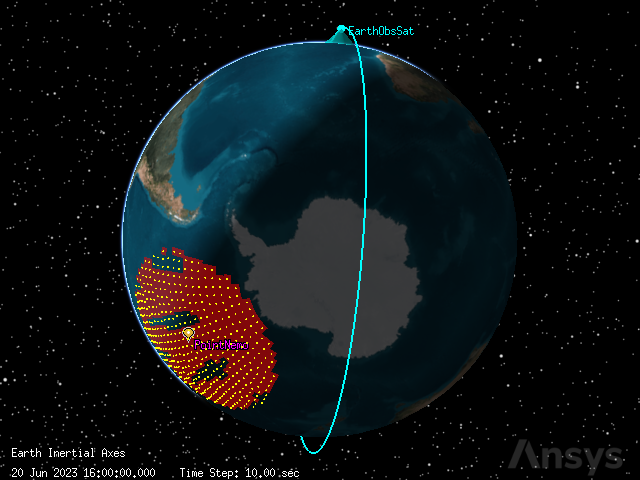

In [36]:
globe_plotter.camera.position = [-3550, 2520, -25360]
globe_plotter.show()

In [37]:
root.play_forward()

## Account for lighting conditions

The satellite graveyard can only be imaged by the satellite's sensor when it is illuminated by daylight. To reflect this constraint, assign a lighting constraint to the Place object representing Point Nemo:

In [38]:
from ansys.stk.core.stkobjects import AccessConstraintType


lighting_constraint = point_nemo.access_constraints.add_constraint(
    AccessConstraintType.LIGHTING
)

Then, constrain the lighting to penumbra or direct sun:

In [39]:
from ansys.stk.core.stkobjects import ConstraintLighting


lighting_constraint.condition = ConstraintLighting.PENUMBRA_OR_DIRECT_SUN

Point Nemo now contains the constraint that must be applied to the entire grid. Set the coverage definition's point definition to use place objects as the reference constraint class:

In [40]:
from ansys.stk.core.stkobjects import CoverageGridClass


sat_grave_coverage.point_definition.grid_class = CoverageGridClass.PLACE

Then, configure the point definition to use an object instance as the grid seed:

In [41]:
sat_grave_coverage.point_definition.use_grid_seed = True

Set Point Nemo as the point definition's seed object:

In [42]:
sat_grave_coverage.point_definition.seed_instance = point_nemo.path

Finally, recompute the accesses:

In [43]:
sat_grave_coverage.compute_accesses()

## Analyze the results

Select the Figure of Merit's Satisfied by Time report and convert it to a pandas ``dataframe``:

In [44]:
satisfied_by_time_lighting_df = (
    figure_of_merit.data_providers.item("Satisfied by Time")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

In [45]:
satisfied_by_time_lighting_df

,time,percent satisfied,area satisfied,percent accum coverage,accum area coverage
0,20 Jun 2023 16:00:00.000000000,0.0,0.0,0.0,0.0
1,20 Jun 2023 16:01:00.000000000,0.0,0.0,0.0,0.0
2,20 Jun 2023 16:02:00.000000000,0.0,0.0,0.0,0.0
3,20 Jun 2023 16:03:00.000000000,0.0,0.0,0.0,0.0
4,20 Jun 2023 16:04:00.000000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...
1436,21 Jun 2023 15:56:00.000000000,0.0,0.0,14.753827408319674,3288625.893054195
1437,21 Jun 2023 15:57:00.000000000,0.0,0.0,14.753827408319674,3288625.893054195
1438,21 Jun 2023 15:58:00.000000000,0.0,0.0,14.753827408319674,3288625.893054195
1439,21 Jun 2023 15:59:00.000000000,0.0,0.0,14.753827408319674,3288625.893054195


The percent satisfaction dropped from $85.65$% to $14.75$% when considering lighting conditions.